<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

/bin/bash: line 1: apt-get: command not found


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


**Part 1 - Computing the CDF**

**A) Background**

Given a numerical approximation of a random field or random function $Y(\mathbf{x})$ over an arbitrary domain $\mathbf{x} \in \Omega$ (which can be thought of as a multidimensional space $\mathbb{R}^n$), we want to calculate its corresponding cumulative density function (CDF) $F(y)$ and probability density function (PDF) $f(y)$ such that these functions are continuous and make the best possible use of the available data. The CDF of $Y(\mathbf{x})$ is given by
\begin{equation*}
    F(y) = \int_{\Omega} \mathbb{I}(y,\mathbf{x}) d \mathbf{x},
\end{equation*}
where the indicator function is given by
\begin{equation*}
    \mathbb{I}(y,\mathbf{x}) =
    \begin{cases}
    1 \quad &: Y(\mathbf{x}) < y, \\
    0 \quad &: \text{otherwise}.
    \end{cases}
\end{equation*}
Differentiating the CDF its PDF $f(y) = \partial_y F(y)$ is then easily recovered. Unfortunately, the integral of the indicator function is in practice difficult to calculate and the common approach is to jump from the analytical expression for $F(y)$ directly to its piecewise constant approximation outlined below.

To illustrate this consider calculating the CDF of $Y(\mathbf{x}_i) = (Y_1, Y_2, \cdots ,Y_n)$ here taken to be a uniformly sampled vector of $n$ discrete points. To calculate a discrete approximation of its CDF we can sort the data to obtain
\begin{equation*}
    F(y) \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{Y_i \leq y}
\end{equation*}
which jumps up by $1/n$ at each data point and thus lets the data discretise the codomain $\Omega_{Y}$, or we can impose a discretisation of $m$ bins $y_0 < y_1 < \cdots < y_m$ and obtain the approximation
\begin{equation*}
    F(y_m) \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{Y_i \leq y_m}
\end{equation*}
which jumps up between bins by $F(y_2) - F(y_1) \neq 1/m$, and takes a constant value within each bin. While this gaurantees a monotonic CDF it is clearly discontinuous and has not made the best use of our data as shown in the example below. Here we consider the function $Y(x_1) = \sin(x_1)^2$ where $x_1 \in [0,2 \pi)$, and plot (a) its CDF $F_Y(y)$, (b) a contour level of its extended CDF $\hat{F}_Y(y)$ as function of $x_1,y$ and (c),(d) the indicator function $\mathbb{I}(y,x_1)$.

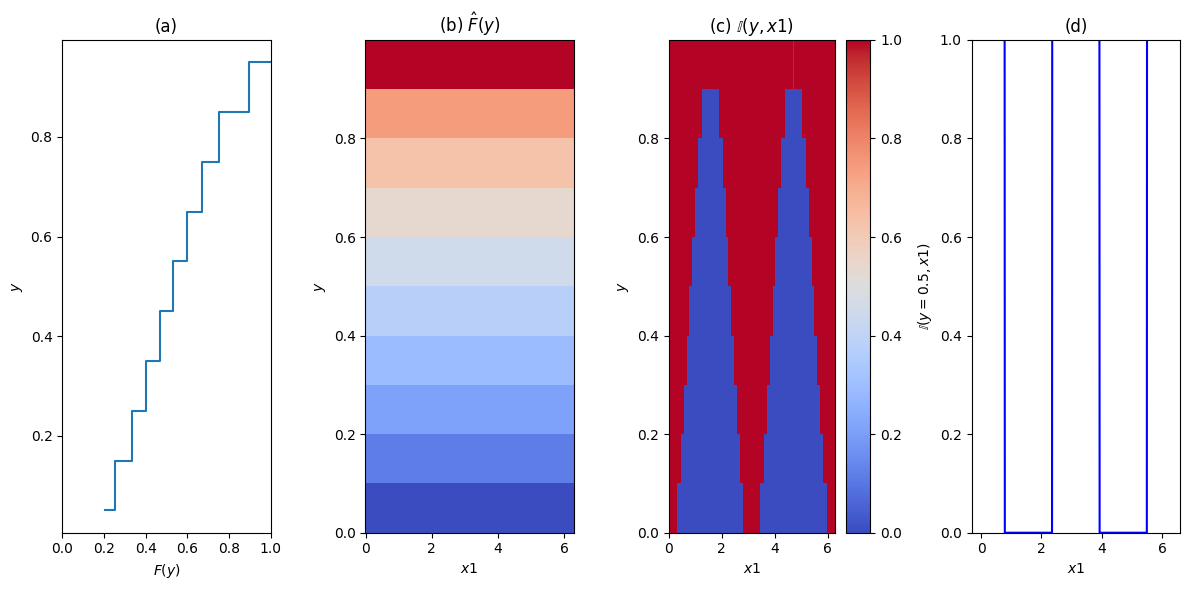

In [2]:
import numpy as np
import matplotlib.pyplot as plt

n    = 10    # Number of bins
n_x1 = 10**3 # Numerical grid for Y(x_1)

# Function
x1 = np.linspace(0,2*np.pi,n_x1)
Y  = lambda x: np.sin(x)**2;

# Indicator function
I  = lambda Y,y_m: [1 if Y_i < y_m else 0 for Y_i in Y];

# Construct CDF
dy  = abs( max(Y(x1)) - min(Y(x1)) )/n;
y   = np.arange(min(Y(x1)),max(Y(x1))+dy,dy);

IYX = np.zeros((n,n_x1))
for i,y_m in enumerate(y[1:]):
  IYX[i,:] = I(Y(x1),y_m) # If Y(x1) < y_n left bin edge

F  = np.mean(IYX,axis=1)  # Integrate out x
y_c= (y[1:] + y[:-1])/2.; # Convert to bin centres

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(141)
ax1.plot(F,y_c,drawstyle='steps-mid')
ax1.set_xlim([0,1])
ax1.set_title(r'(a)')
ax1.set_ylabel(r'$y$')
ax1.set_xlabel(r'$F(y)$')

ax2 = fig.add_subplot(142)
ax2.set_title(r'(b) $\hat{F}(y)$')
ax2.pcolormesh(x1,y_c,np.outer(np.ones(n_x1),F).T,cmap='coolwarm')
ax2.set_xlabel(r'$x1$')
ax2.set_ylabel(r'$y$')

ax3 = fig.add_subplot(143)
ax3.set_title(r'(c) $\mathbb{I}(y,x1)$')
im = ax3.pcolormesh(x1,y_c,IYX,cmap='coolwarm')
fig.colorbar(im, ax=ax3)
ax3.set_xlabel(r'$x1$')
ax3.set_ylabel(r'$y$')

ax4 = fig.add_subplot(144)
ax4.plot(x1,I(Y(x1),0.5),'b')
ax4.set_ylim([0,1])
ax4.set_title(r'(d)')
ax4.set_xlabel(r'$x1$')
ax4.set_ylabel(r'$\mathbb{I}(y=0.5,x1)$')

plt.tight_layout()
plt.show()

In the example above we have (1) implicitly assumed a basis of piecewise constant functions and (2) regarded the random field not as a continuous function of space but instead as a vector of grid point evaluations. How do we refine this "binning" approach? We now show that, by choosing the appropriate function space, it is possible to directly integrate the indicator function applied to an arbitrary function, i.e. the analytical CDF using a finite element method.

**B) Theory**

To address the first point we can define an appropriate function space $V_F$ for $F$, which for simplicity we choose the space of square integrable functions
\begin{equation*}
    F \in V_F \subset L^2(\Omega_Y), \quad \text{where} \quad F: \Omega_Y \to [0,1] \quad \text{s.t.} \; \int F^2 dy < \infty,
\end{equation*}
and define the set of basis functions $V_F = span\{\phi_i(y)\}$ such that
\begin{equation*}
    F(y) = \sum_i F_i \phi_i(y).
\end{equation*}
While this does not garauntee continuity we will see that this is not strictly necessary if we only require $f(y)$ to be continuous. To address the second point we now consider the projection of $F(y)$ into $V_F$ as defined by
\begin{equation*}
    \int_{\Omega_Y \times \Omega} \hat{F} \hat{v} \; dy d \mathbf{x} = \int_{\Omega_Y \times \Omega} \mathbb{I}(y,\mathbf{x}) \hat{v} \; dy d \mathbf{x},
\end{equation*}
where $\hat{v},\hat{F} \in \hat{V}_F$ denotes the extension of $v,F \in V_F$ into $\Omega$. Substituting in for $\hat{F}$ and considering the projection component-wise we obtain
\begin{equation*}
    \sum_{i,j} \left[ \int_{\Omega_Y \times \Omega} \hat{\phi}_i \hat{\phi}_j \; dy d \mathbf{x} \right] f_j = \sum_i \left[ \int_{\Omega_Y \times \Omega} \mathbb{I}(y,\mathbf{x}) \hat{\phi}_i(y,\mathbf{x}) \; dy d \mathbf{x} \right],
\end{equation*}
where the left hand side denotes the bilinear form and the right hand side the linear form. As $\mathbb{I}(y,\mathbf{x})$ is analytic and $Y(\mathbf{x})$ is treated as a random function of space we have not made any approximation of the right hand side!


Applying this equation to the example problem, we find that the precise statement of these function spaces for $\hat{F}$ and its basis functions $\hat{v}$ is
\begin{equation}
    \hat{V}_F = V_F \times R,
\end{equation}
the space of square integrable functions $V_F$ times $R$ the space of functions which are constant over the whole domain. These spaces correspond to the $y$ and the $x_1$ axis of frame (b) in the example shown above, whose 1D projection is shown in frame (a). In frames (c) and (d)  we highlight the discontinuous dependence of the indicator function on $y,x_1$. To realise these function spaces and this projection operation numerically we will make use of the finite element code [firedrake](https://www.firedrakeproject.org/).

**c) Numerical implementation**

We begin by constructing a mesh for $\mathbf{x} \in \Omega$ which if 1D is an interval mesh and if 2D a rectangular mesh. As we have an analytical expression or at least have a continuous representation of our data we can replace the real space $R$ by a single Discrete Galerkin element of zero order (DG0). Extruding this mesh into $y \in \Omega_Y$ and ascribing to it $Ny$ elements of type DG1 we specify a piecewise linear function space for $F(y)$ that is discontinuous between elements. After constructing the CDF we will justify our choice of these function spaces.

In [132]:
from firedrake import *
from firedrake.__future__ import interpolate

# Construct the mesh
Ny   = 10 # Vary the number of mesh cells
m_x  = IntervalMesh(1,0,2*np.pi); cell_type = "interval";  # x-direction
mesh = ExtrudedMesh(m_x, layers=Ny,layer_height=1./Ny,extrusion_type='uniform') # y-direction

# Set the function-space \hat{V}_F
R   = FiniteElement(family="DG" ,cell=cell_type,degree=0, variant="equispaced")
V_F = FiniteElement(family="DG",cell="interval",degree=1, variant="equispaced")

elt_RVF = TensorProductElement(R,V_F)
V_hat_F = FunctionSpace(mesh,elt_RVF)

With the function spaces defined we then define the indicator function $\mathbb{I}(y,\mathbf{x})$ which acts on the random function $Y(\mathbf{x})$

In [133]:
# Define the indicator function
x1,y = SpatialCoordinate(mesh)
Indicator = conditional(sin(x1)**2  < y, 1, 0)

We then declare the bilinear and linear forms for the left and right hand sides of our equation and then we solve the equation, by defining $F$ to be a function holding the solution and then passing this along with $a$ and $L$ to a solver. An additional argument we specify when constructing the linear form is the degree of the quadrature rule used to integrate the right hand side. A high order rule is necessary to contend with the discontinuous dependency of the indicator function as shown in frames (c) and (d) of the earlier figure.

In [134]:
u = TrialFunction(V_hat_F)
v = TestFunction(V_hat_F)

a = inner(u,v) * dx
L = inner(Indicator,v) * dx(degree=250) # Vary the order of the quadrature rule

F_hat = Function(V_hat_F)
solve(a == L,F_hat)

To recover the 1D function $F(y)$ we then create a new mesh and ascribe a function space upon which we can define a function to contain the data associated with the extended function's $\hat{F}(y,\mathbf{x})$ DOF.

In [135]:
# Define a mesh,function space & the CDF F which lives in this space
m_y = IntervalMesh(Ny,0,1);
V_F = FunctionSpace(mesh=m_y,family="DG",degree=1);
F   = Function(V_F)

# create new function y_Fs on function space V
y,  = SpatialCoordinate(m_y)
y_Fs= assemble(interpolate(y,V_F)) # Creates a function y in V_F

# Now we sort these in ascending order
# This is because the DOFs for the extended mesh are in ascending order
indx = np.argsort(y_Fs.dat.data)

# Pass the data from F_hat into F
F.dat.data[indx] = F_hat.dat.data[:]

Finally we can plot this out using firedrake's inbuilt routine

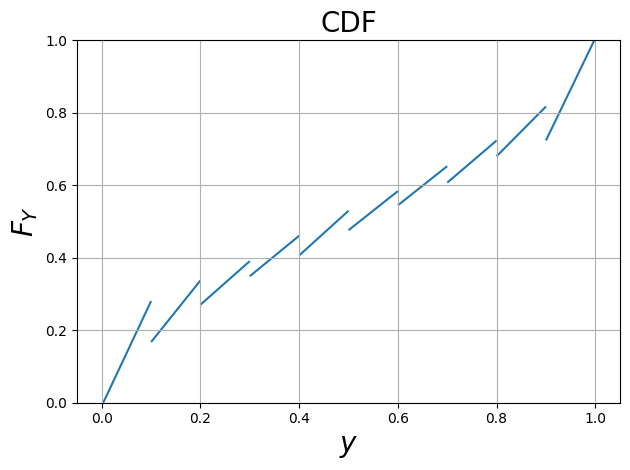

In [136]:
import matplotlib.pyplot as plt
from firedrake.pyplot import plot

Line2D = plot(F,num_sample_points=50)
plt.title(r'CDF',fontsize=20)
plt.ylabel(r'$F_Y$',fontsize=20)
plt.xlabel(r'$y$',fontsize=20)
plt.ylim([0,1])
plt.tight_layout()
plt.grid()
plt.show()

**D) Slope limiter**

In order to construct a CDF we must have a non-decreasing and right-continuous function $F(y)$. As we chose the space of piecewise linear functions rather than piecewise constant functions we cannot guarantee these conditions are satisfied and we must therefore apply a slope limiter in order to construct a valid CDF. Indeed by choosing an intentionally small qadrature degree we have forced our approximation of $F(y)$, as shown in the previous figure, to deviate from what constitutes a valid CDF. Given that this reassignment of slopes is a nonlinear process we shall use an iterative relaxation method to ensure convergence of the slope updating scheme.

 
Our algorithm assumes a finite element discretisation consisting of $N_e$ piecewise discontinuous linear finite elements such that we have $2N_e$ degrees of freedom (dofs) and $N_e + 1$ facets (the boundary between elements). In the above example we use $10$ elements and so there is $11$ facets. We assume the dofs correspond to point evaluations at the left and right endpoints of each elements. In order to update these dofs we must calculate a set of jump conditions enabling us to limit the slope.

To calculate these jump conditions we label the value approaching the left of a arbitrary facet $a_-$ and $a_+$ the value approaching from the right. Using this notation we can then calculate the jump (at iteration $n$) at each facet according to

\begin{equation}
j^n = \begin{cases} a^n_+-a^n_-, \qquad\qquad if \; a^n_+ < a^n_-, \\ min(a^n_+,a^0_-) - a^n_-\end{cases}
\end{equation}

where the first condition is equal to the amount by which the CDF is currently decreasing at this facet, while the second condition is the amount by which we can adjust the slope back towards its original CDF before the slope limiter was applied, all whilst maintaining a non-decreasing CDF. This condition is implemented below.

In [137]:
def jump_condition(a_n_minus, a_n_plus, a_0_minus):
    if a_n_plus < a_n_minus:
        return a_n_plus-a_n_minus
    else:
        return min(a_n_plus, a_0_minus) - a_n_minus

As each element $e$ has a set of two jump values associated to it, one at its left facet and one at its right facet, we must choose the minimum of these two values (i.e. the most negative of the two) such that all negative slopes of the piecewise linear elements of the CDF are removed that is $j^n = min\{j^n_{l},j^n_r\}$. This of course comes with the price of increasing the positive overshoot at some facets. The calculation of $j^n$ is implemented below on a cell by cell basis, in the form of a function which takes in the orginal CDF $F_0$ befoe the slope limiter was applied and the current CDF $F$ resulting from the last application of the slope limiter.

In [138]:
def jumps(F, F_0):

    # The 2*N_e dofs contained in F are stored from left to right
    # we reshape the array to be of dimensions (N_e,2), so the first
    # axis indexs the element and the second its left and right dof.

    # Create an array containing a_0_minus,a_0_plus
    celldata_0 = F_0.dat.data[:].reshape((-1, 2))

    # Create an array containing a_n_minus,a_n_plus
    celldata_n = F.dat.data[:].reshape((-1, 2))
    ne = celldata_n.shape[0]
    
    # Create an empty array to store the jumps
    jumps = np.zeros(ne)

    # Go through the cells from left to right
    for e in range(ne):

        # (1) cell data
        # e - 1
        if e == 0:
            # At the left most boundary the CDF from the lower minus side 
            # is by definition 0, i.e. F(-∞) = 0
            cell_n_em1 = np.zeros(2)
            cell_0_em1 = np.zeros(2)
        else:
            cell_n_em1 = celldata_n[e-1, :]
            cell_0_em1 = celldata_0[e-1, :]
        # e
        cell_n_e = celldata_n[e, :]
        cell_0_e = celldata_0[e, :]

        # e + 1
        if e == ne-1:
            # At the right most boundary the CDF from the upper plus side 
            # is by definition 1, i.e. F(+∞) = 1
            cell_n_ep1 = np.ones(2)
        else:
            cell_n_ep1 = celldata_n[e+1, :]
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        # (2) Calculate the jump conditions & then take their minimum
        left = jump_condition(cell_n_em1[1], cell_n_e[0], cell_0_em1[1])
        right = jump_condition(cell_n_e[1], cell_n_ep1[0], cell_0_e[1])
        jumps[e] = min(left, right)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    return jumps

Having calculated the jumps we then add $j^n$ to each left hand dof and subtract $j^n$ from each right hand dof. This is done in an iterative fashion by choosing a small update size $\alpha \approxeq 0.1$ such that the final update at each iteration is given by

\begin{align*} 
\text{dof}_{left} &= \text{dof}_{left} + \alpha j^n, \\ 
\text{dof}_{right} &= \text{dof}_{right} - \alpha j^n,
\end{align*}

This procedure continues until the Cartesian norm $||j^n - j^{n+1}||_2/||j^{n-1}|| < \epsilon$ falls below a user defined threshold or if the slopes of elements cannot prevented from being negative.

Iteration i=10  error =  0.2449977543590163 slope = 0.058050721831114815 



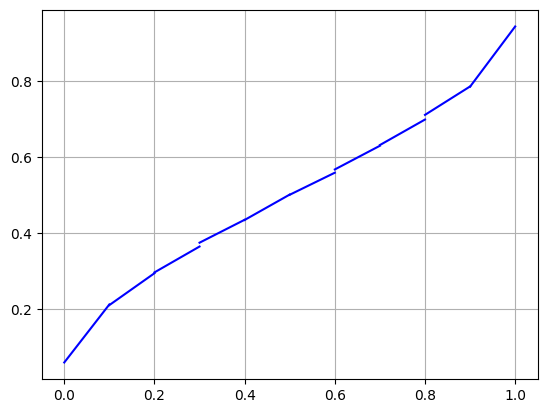

Iteration i=20  error =  0.21094228536288592 slope = 0.05759236533978407 



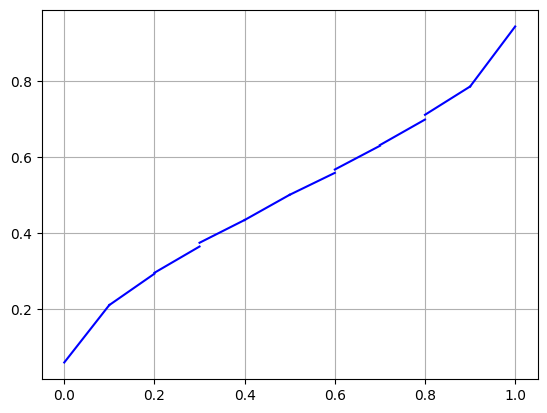

Iteration i=30  error =  0.13978142511233554 slope = 0.05754314968627949 



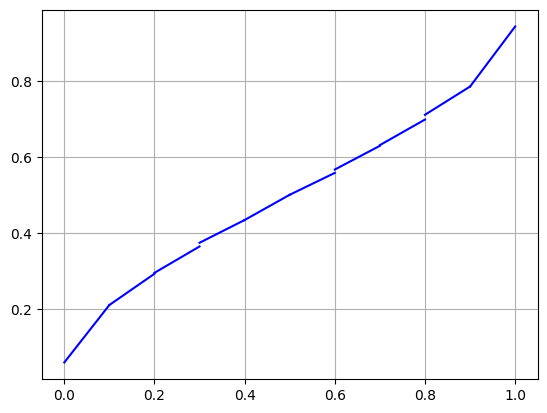

Iteration i=40  error =  0.11452199124594921 slope = 0.05753786519572324 



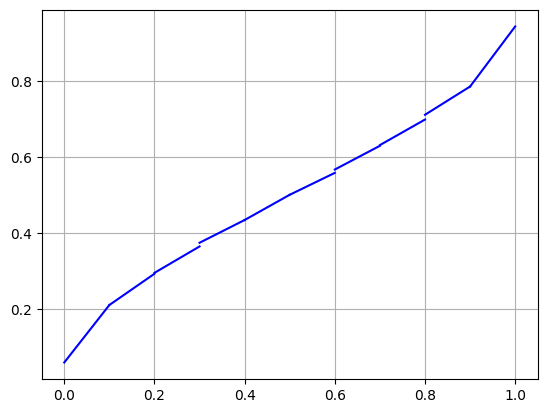

Iteration i=50  error =  0.11142527068008262 slope = 0.05753729777787031 



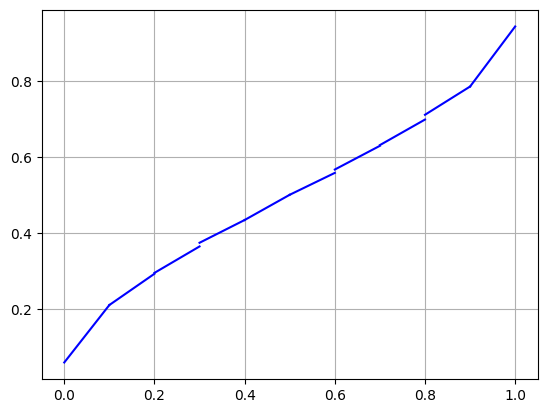

In [139]:
import copy
    
# Create a copy of the original not slope limited CDF
F_0 = copy.deepcopy(F)

# Grab the number of elements
ne  = F_0.dat.data[:].reshape((-1, 2)).shape[0]

# A) Relaxation loop
error = 1
iter = 0
slope = -1
jo = np.zeros(ne)
alpha = 0.1
while (error > 0.01 or slope < 0) and (iter < 50):

    # (1) Update dats
    jn = jumps(F, F_0)
    F.dat.data[:].reshape((-1, 2))[:, 0] -= alpha*jn
    F.dat.data[:].reshape((-1, 2))[:, 1] += alpha*jn

    # (2) Error
    iter += 1
    if np.linalg.norm(jn) == 0:
        error = 0.
    else:
        error = np.linalg.norm(jn - jo, 2)/np.linalg.norm(jn, 2)
    jo = jn

    # (3) Calculate the slope
    slopes = F.dat.data[:].reshape((-1, 2))[:, 1] - F.dat.data[:].reshape((-1, 2))[:, 0]
    slope = np.min(slopes)
    if abs(slope) < 1e-12:
        slope = 0.

    # (4) Plot out the CDF as the limiter operates
    if iter%10==0:
        print('Iteration i=%d' % iter, ' error = ', error, 'slope =', slope, '\n')
        l = np.arange(0,1,0.1)
        r = np.arange(0.1,1.1,0.1)
        X = np.vstack([l,r]).T
        for i in range(ne):
            plt.plot(X[i,:],F.dat.data[:].reshape((-1, 2))[i,:],'b')
        plt.grid()
        plt.show()

# B) Remove remaining illegal discontinuities not captured during the relaxation
jn = jumps(F, F_0)
F.dat.data[:].reshape((-1, 2))[:, 0] -= jn
F.dat.data[:].reshape((-1, 2))[:, 1] += jn

As demonstrated above the slope limiter correctly removes negative slopes present and thus garauntees a valid CDF. This was made possible because we have chosen a discontinuous piecewise linear function space 'DG1'. Had we however chosen a higher order element such as a discontinuous piecewise quadratic element or a piecewise continuous element, we could not have adjusted the slope of each element, and this would not have been possible. The function space 'DG1' for $F(y)$ is therefore in part justfied by the need to maintain a non-decreasing and right-continuous function, which with the exception of a piece-wise constant discontinuous function space 'DG0' is otherwise not possible using any other element.

As we now proceed to show in **Part 2** the 'DG0' element, while suitable for obtaining the CDF, cannot be used if we wish to recover a piecewise continuous approximation of the PDF. This implies that 'DG1' is the lowest order function-space we can choose for this projection, which albeit requires the use of slope-limiters to produce a non-decreasing and right-continuous CDF as evidenced by the previous figure, does suceed in producing a higher order approximnation of the CDF as well as a continuous PDF.